# **Implémentation d'un modèle de scoring**
## **Notebook 1/6 - Analyse Exploratoire**
*Sofia Chevrolat (Novembre 2020)*
___
Cette étude vise à réaliser un modèle permettant de prédire le risque de défaut de remboursement d'un prêt pour un client donné. Ce modèle doit être basé sur une variété de données (personnelles, en provenance de différentes sources bancaires, etc.).

Ce modèle est destiné à être servi via une API, elle-même appelée via un dashboard interactif. Le modèle devra donc être exporté une fois finalisé.
___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils et les encouragements !_
___


Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies et fonctions utiles
- 0.2 Chargement et description du jeu de données

**1. Analyse exploratoire**
- 1.1 Valeurs manquantes
- 1.2 Distributions
    * 1.2.1 Features quantitatives
    * 1.2.2 Features qualitatives
    * 1.2.3 Remboursement des prêts
- 1.3 Anomalies
- 1.4 Corrélations avec le risque de défaut TARGET
    * 1.4.1 Corrélations les plus fortes
    * 1.4.2 Focus : corrélation avec l'ancienneté au poste actuel DAYS_EMPLOYED
    * 1.4.2 Focus : corrélation avec l'âge DAYS_BIRTH
    * 1.4.3 Focus : corrélation avec les indicateurs synthétiques EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3
    
**2. Conclusion**

___
### 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES ET FONCTIONS UTILES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from sys import path
path.append("./Resources/functions")

import helper_functions as hf
import graphical_functions as gf

___
#### 0.2 CHARGEMENT ET DESCRIPTION DU JEU DE DONNÉES

In [4]:
app_train = pd.read_csv("./Resources/datasets/origin/application_train.csv")

app_test = pd.read_csv("./Resources/datasets/origin/application_test.csv")

bureau_balance = pd.read_csv("./Resources/datasets/origin/bureau_balance.csv")

bureau = pd.read_csv("./Resources/datasets/origin/bureau.csv")

credit = pd.read_csv("./Resources/datasets/origin/credit_card_balance.csv")

installments = pd.read_csv("./Resources/datasets/origin/installments_payments.csv")

cash = pd.read_csv("./Resources/datasets/origin/POS_CASH_balance.csv")

prev_app = pd.read_csv("./Resources/datasets/origin/previous_application.csv")

In [5]:
hf.describe_dataset({'App Train':app_train,
                     'App Test': app_test, 
                     'Bureau': bureau,
                     'Bureau Balance': bureau_balance,
                     'Credit Card Balance:' : credit,
                     'Installments Payments': installments,
                     'POS cash balance': cash,
                     'Previous App': prev_app})

Les données se décomposent en 8 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes
1              App Train        307511             122
2               App Test         48744             121
3                 Bureau       1716428              17
4         Bureau Balance      27299925               3
5   Credit Card Balance:       3840312              23
6  Installments Payments      13605401               8
7       POS cash balance      10001358               8
8           Previous App       1670214              37

Ces fichiers contiennent les informations suivantes :

<table style="width:100%;align:'left'">
  <tr>
    <th>File</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>App Train</td>
    <td>Main training data. <br>One row represents one loan.
    </td> 
  </tr>
  
  <tr>
    <td>App Test</td>
    <td>Main testing data. <br> One row represents one loan.</td>
  </tr>
    
  <tr>
    <td>Bureau</td>
    <td>All client's previous credit from other financial institutions <br>
        for clients who have a loan in the sample.
    </td>
  </tr>
 
  <tr>
    <td>Bureau Balance</td>
    <td>Monthly balances of previous credits in bureau. <br>
        The table contains one row for each month of history of <br>
        every previous credit in bureau.
    </td> 
  </tr>

  <tr>
    <td>Credit Card Balance</td>
    <td>Monthly balance snapshots of previous cardit cards of the applicant.<br>
        The table contains one row for each month of history of every <br>
        previous credit in Home Credit (consumer credit and cash loans)<br>
        related to loans in our sample. 
    </td> 
  </tr>

  <tr>
    <td>Installments payments</td>
    <td>Repayment history for the previously disbursed credits related <br>
        to the loans in the sample.<br>
        The table contains :<br>
        - one row for every payment made
        - one row each for missed payment
        One row = one payment of one installment OR one installment <br>
        corresponding to one payment of one previous Home Credit related<br>
        to loans in our sample.
    </td> 
  </tr>
    
  <tr>
    <td>POS cash balance</td>
    <td>Monthly balance snapshots of previous POS and cash loans that <br>
        the applicant had.<br>
        The table contains one row for each month of history of every <br>
        previous credit in Home Credit (consumer credit and cash loans)<br>
        related to loans in our sample.
    </td> 
  </tr>

  <tr>
    <td>Previous App</td>
    <td>Previous applications for loans at Home Credit of clients <br>
        who have loans in the application data.<br>
        The table contains one row for each previous application<br>
        related to loans in the sample.
    </td> 
  </tr>
</table>

Ces fichiers sont reliés comme suit :

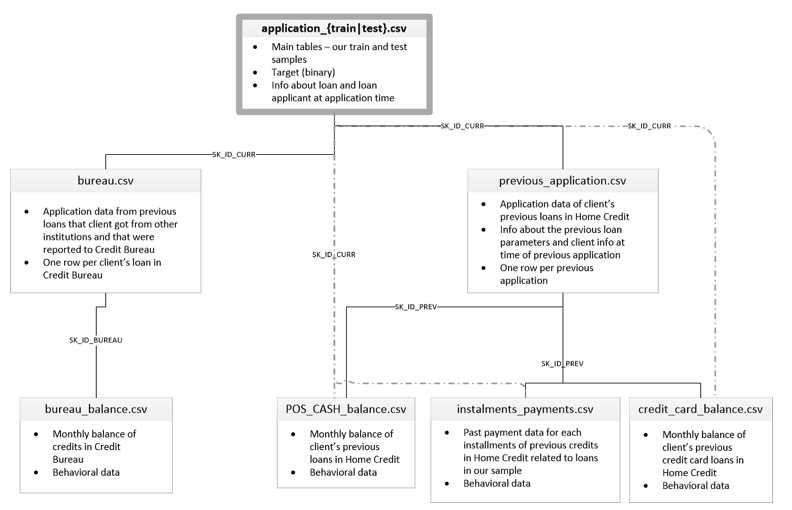

___
### 1. Analyse Exploratoire

Nous allons ici explorer plusieurs aspects du jeu de données :
- Les valeurs manquantes
- La distribution de certaines features d'intérêt
- Les anomalies éventuelles
- Les corrélations
___

In [6]:
interesting_cols_quant = ['AMT_ANNUITY',
                          'AMT_CREDIT',
                          'AMT_GOODS_PRICE',
                          'AMT_INCOME_TOTAL',
                          'CNT_CHILDREN',
                         'CNT_FAM_MEMBERS',
                         'DAYS_BIRTH',
                          'DAYS_EMPLOYED']

interesting_cols_qual = ['CNT_CHILDREN',
                         'CNT_FAM_MEMBERS',
                         'NAME_CONTRACT_TYPE',
                         'NAME_EDUCATION_TYPE',
                         'NAME_FAMILY_STATUS',
                         'NAME_HOUSING_TYPE',
                         'NAME_INCOME_TYPE',
                         'OCCUPATION_TYPE',
                         'ORGANIZATION_TYPE']     

interesting_cols = interesting_cols_quant + interesting_cols_qual                

___
#### 1.1 VALEURS MANQUANTES

In [7]:
missing_values_df = hf.get_missing_values_percent_per(app_train)\
                      .drop(columns=["Percent Filled", "Total"])\
                      .sort_values("Percent Missing", ascending=False)

In [8]:
print("{:2.2f}% des features contiennent plus de 50% de valeurs manquantes"\
.format(len(missing_values_df[missing_values_df["Percent Missing"]>50])/len(missing_values_df)*100))

33.61% des features contiennent plus de 50% de valeurs manquantes


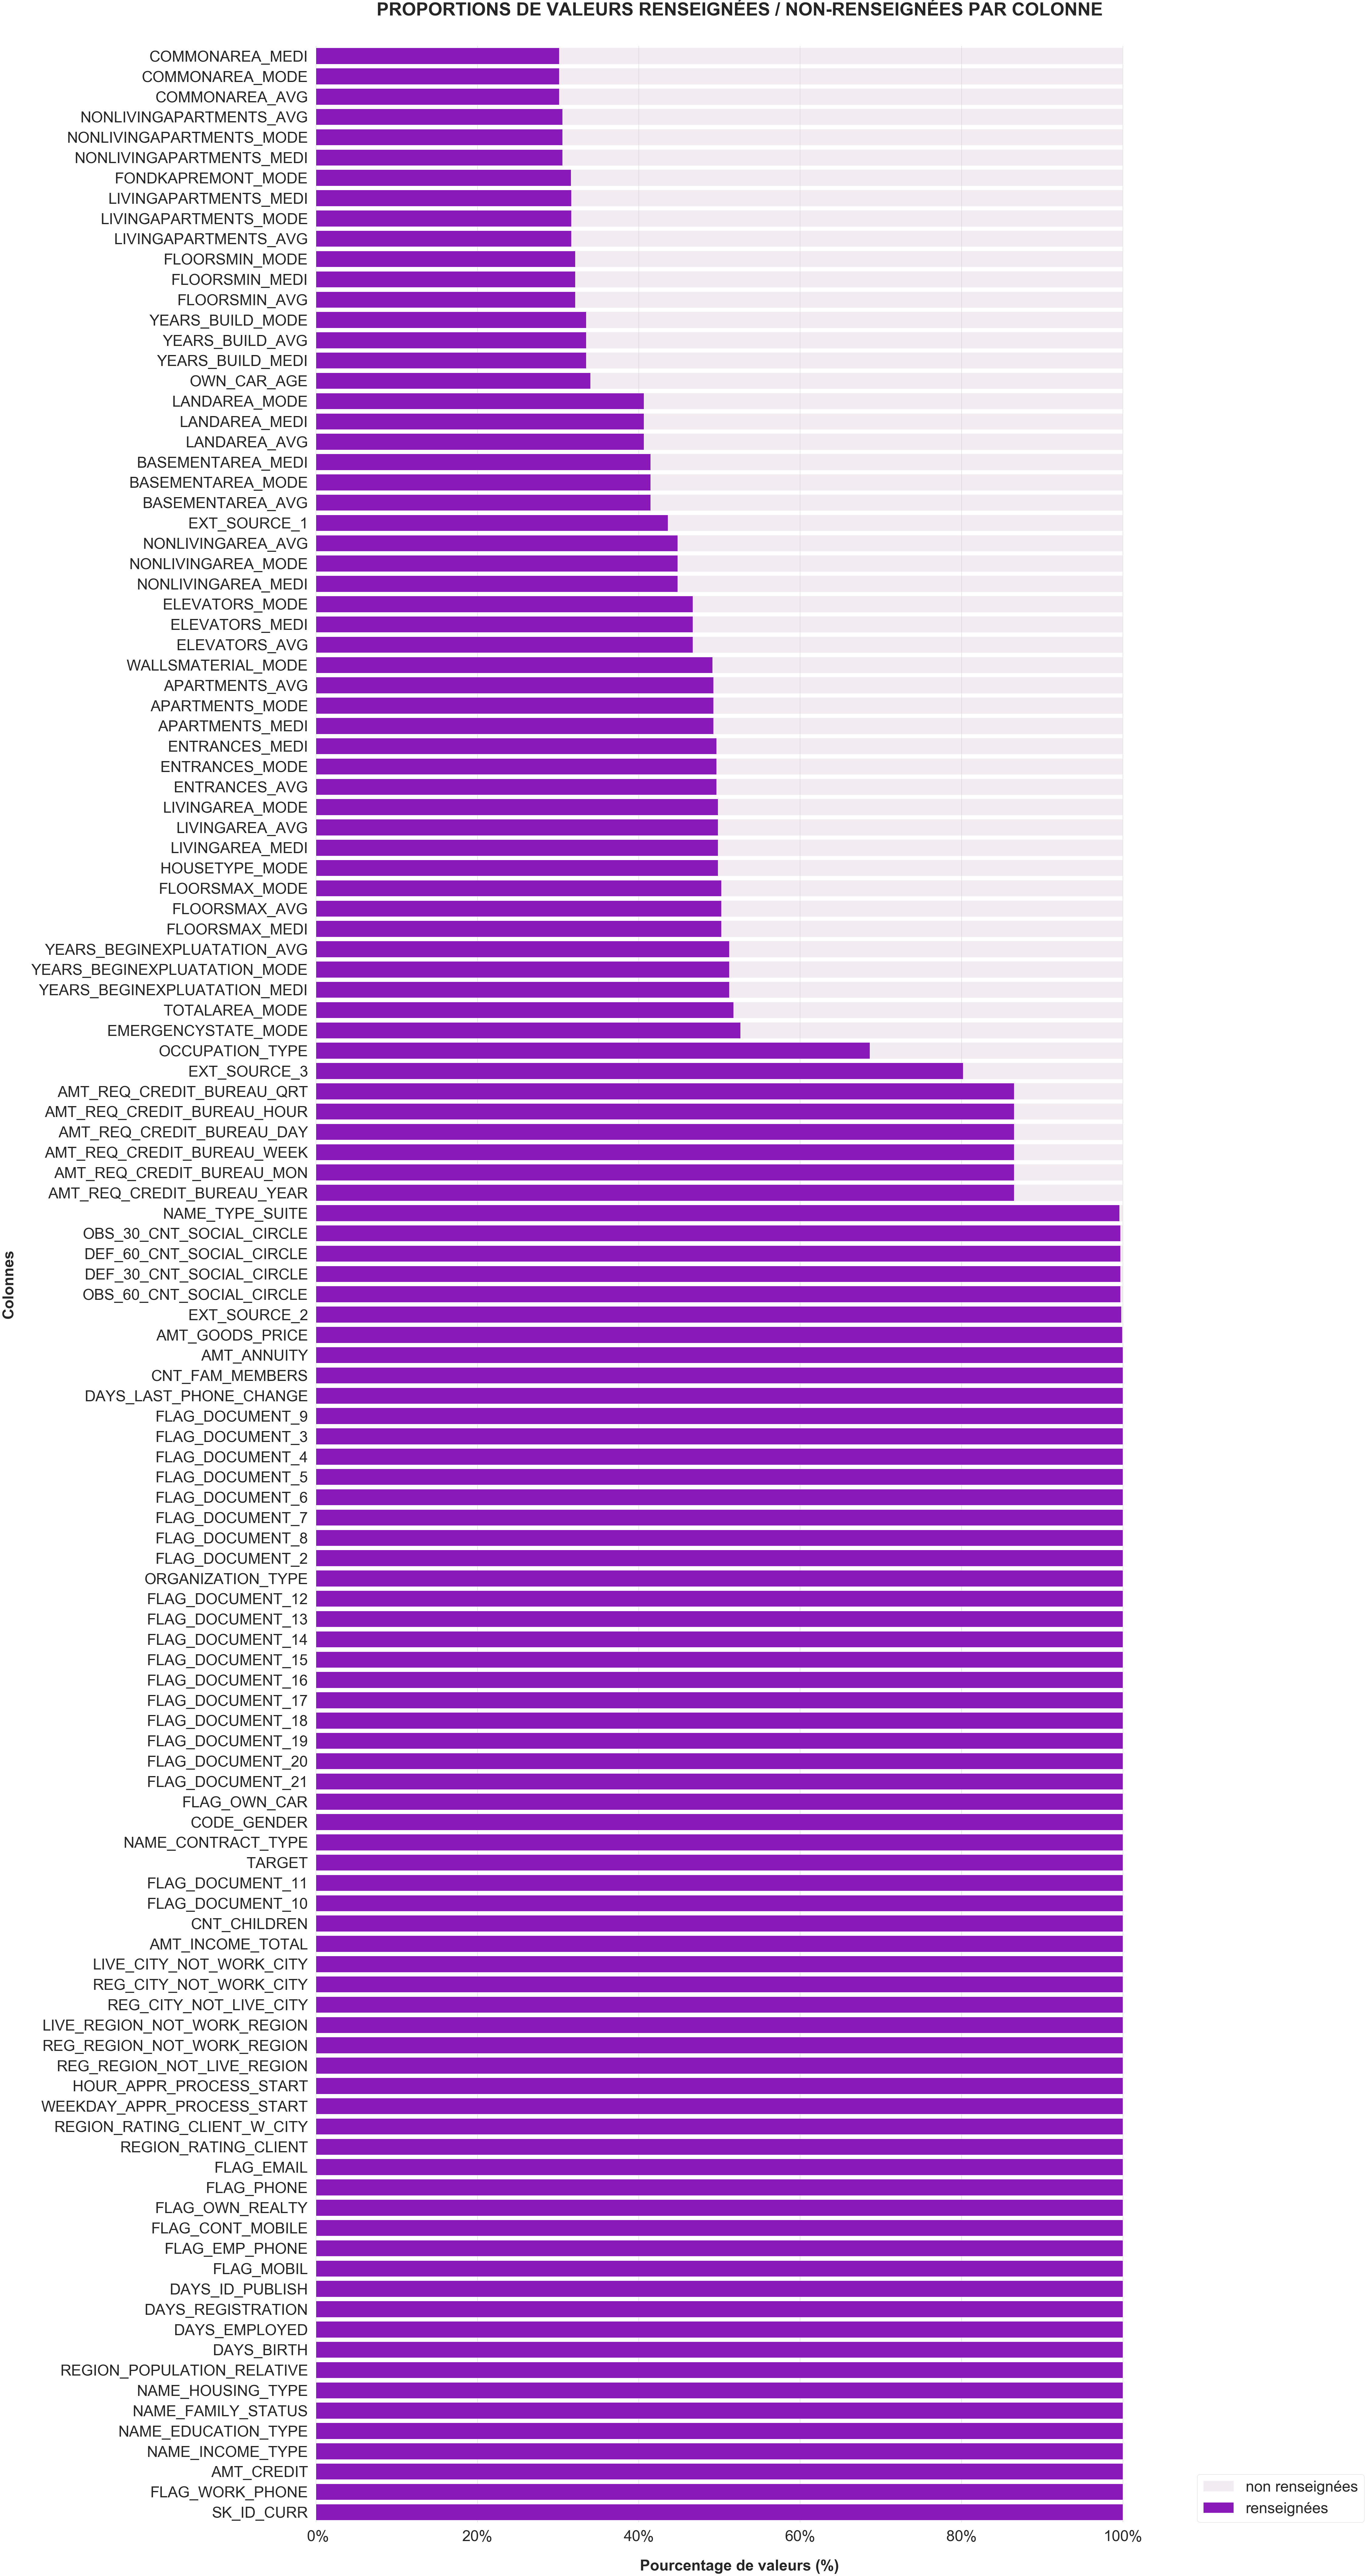

In [12]:
gf.plot_percentage_missing_values_for(app_train, 50, 150)

Un tiers des colonnes présente plus de 50% de valeurs manquantes. 

Ce sera une information à considérer lors de l'étape de modélisation.

Ce taux semble meilleur pour les colonnnes qui semblent être intéressantes d'un point de vue humain.

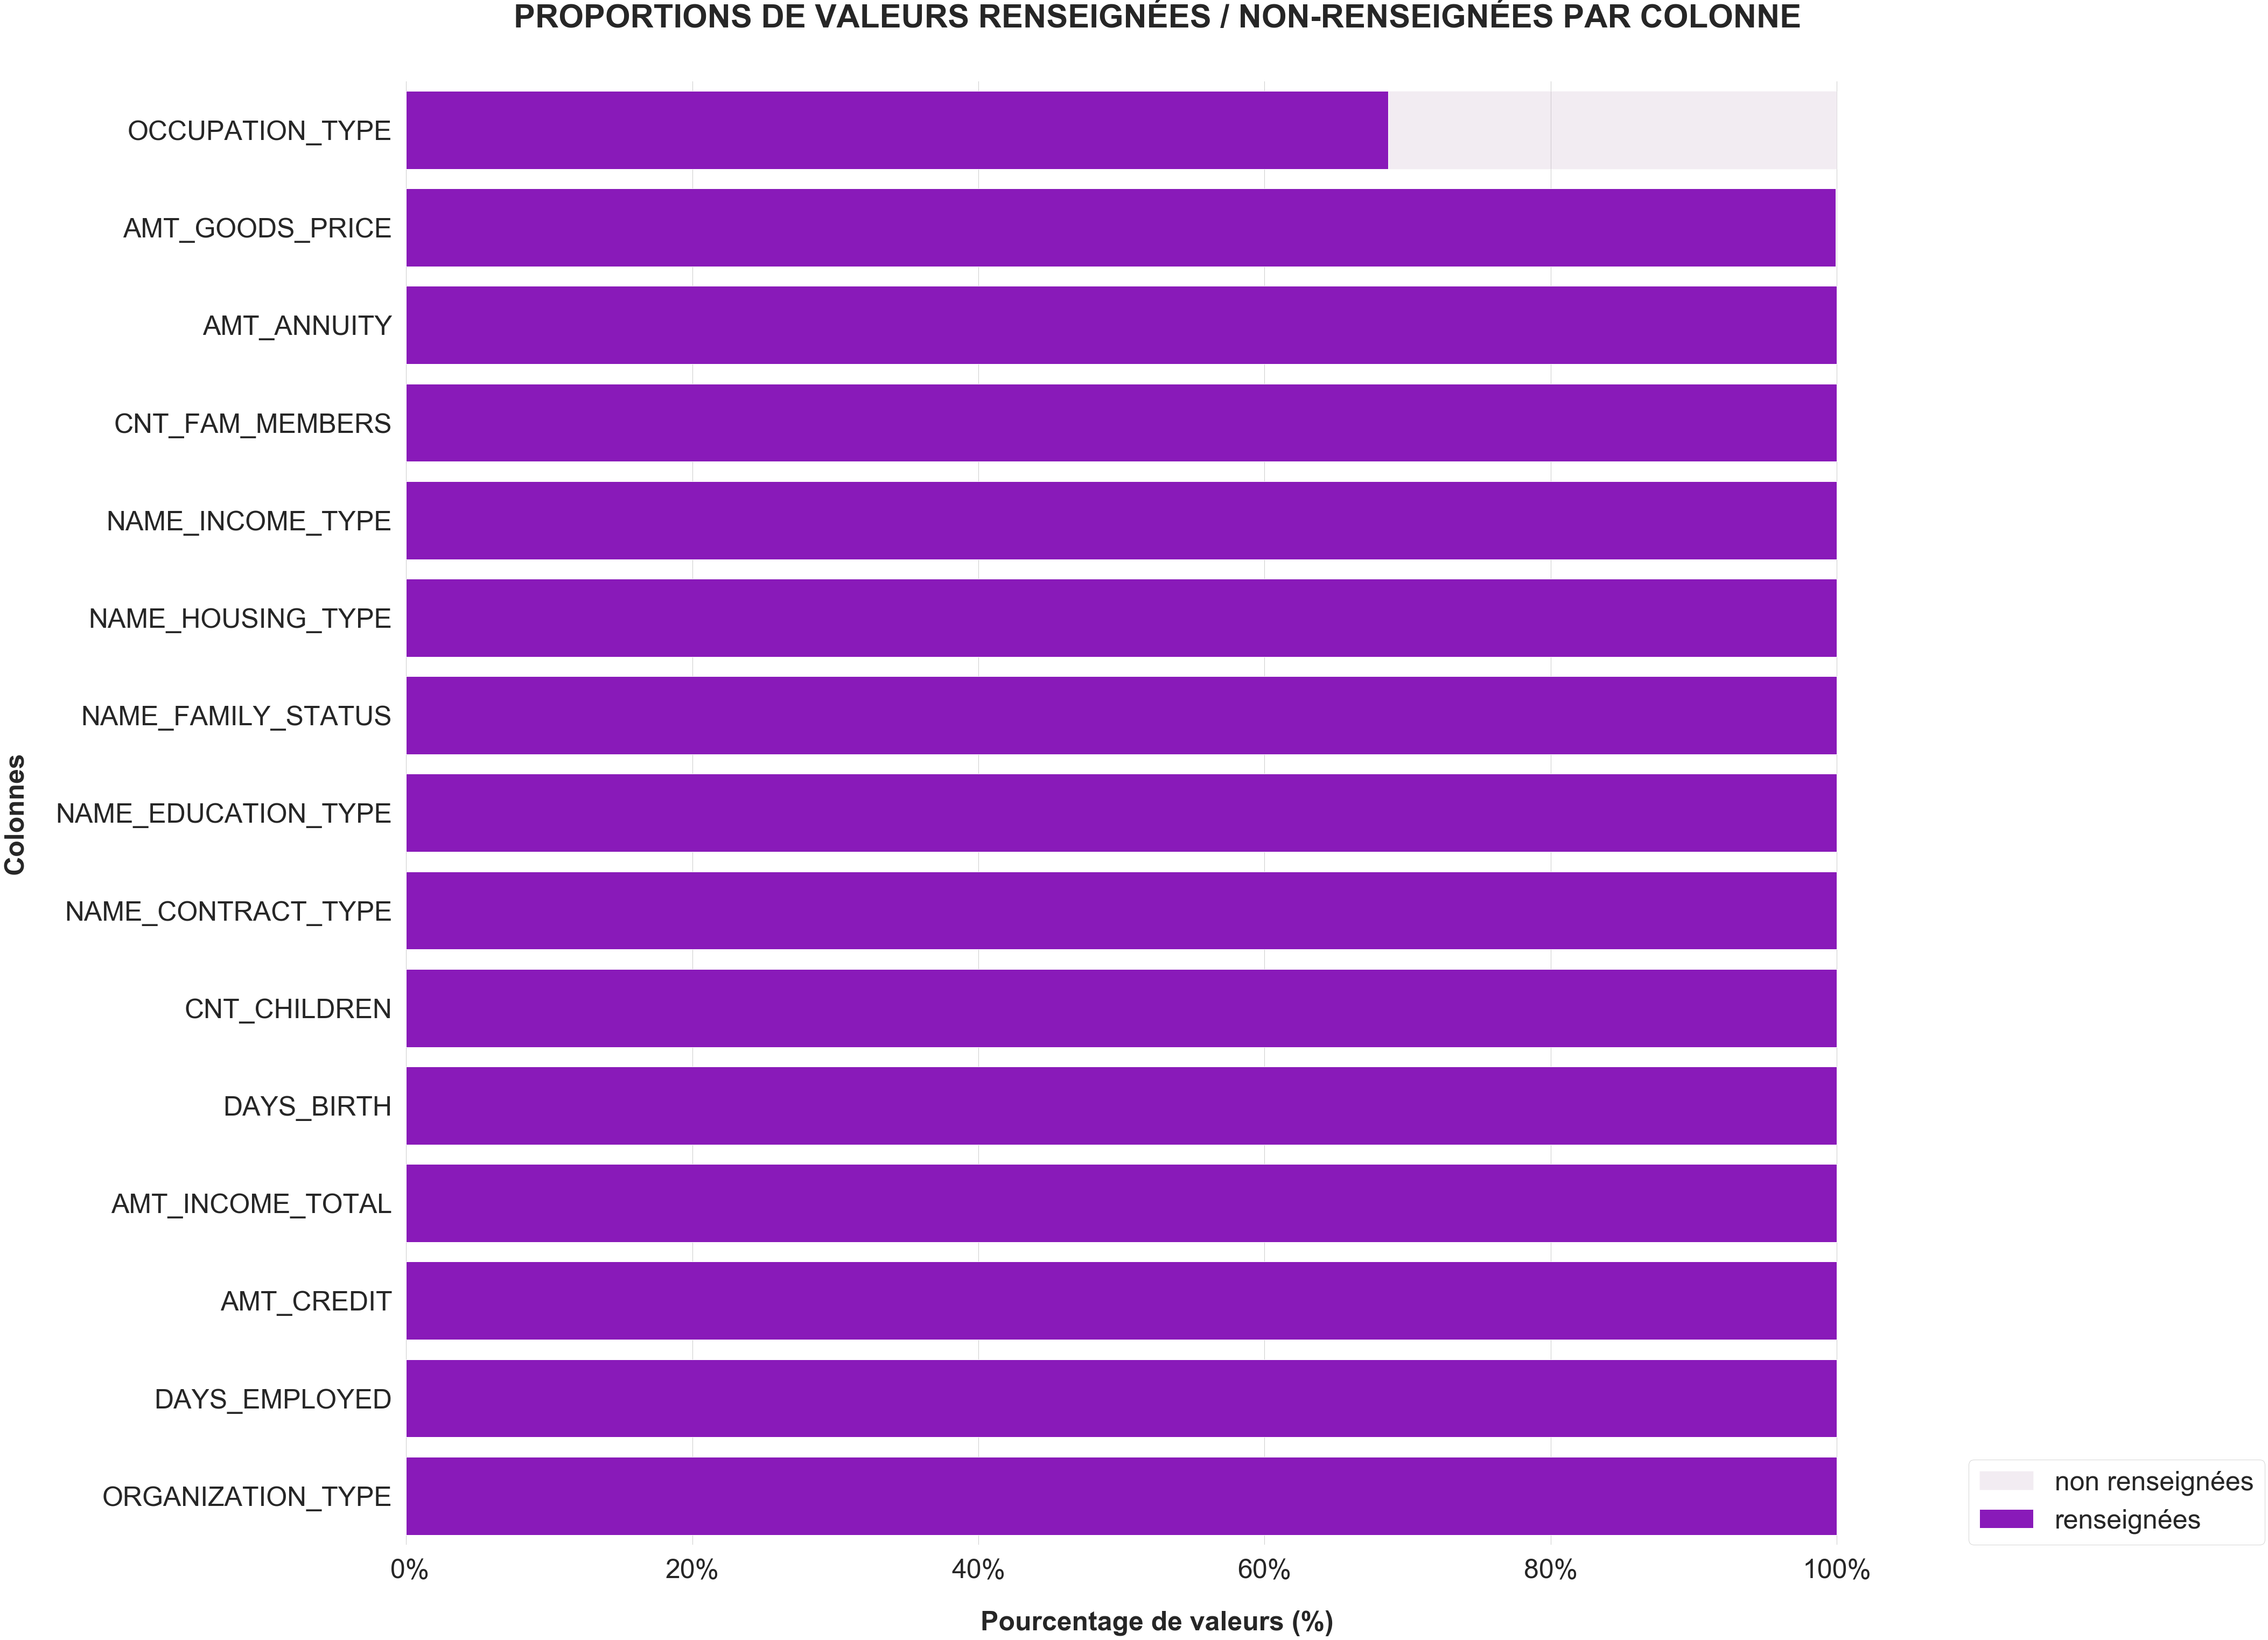

In [9]:
gf.plot_percentage_missing_values_for(app_train[interesting_cols], 50, 50)

___
#### 1.2 DISTRIBUTIONS

___
##### 1.2.1 _<u>Features quantitatives</u>_

In [10]:
pd.concat([app_train[interesting_cols_quant].mode().T.rename(columns={0:"Mode"}),
           app_train[interesting_cols_quant].median(),
           app_train[interesting_cols_quant].mean()], axis=1)\
  .rename(columns={0:"Médiane", 1:"Moyenne"})

Mode   Médiane        Moyenne
AMT_ANNUITY         9000.0   24903.0   27108.573909
AMT_CREDIT        450000.0  513531.0  599025.999706
AMT_GOODS_PRICE   450000.0  450000.0  538396.207429
AMT_INCOME_TOTAL  135000.0  147150.0  168797.919297
CNT_CHILDREN           0.0       0.0       0.417052
CNT_FAM_MEMBERS        2.0       2.0       2.152665
DAYS_BIRTH        -13749.0  -15750.0  -16036.995067
DAYS_EMPLOYED     365243.0   -1213.0   63815.045904

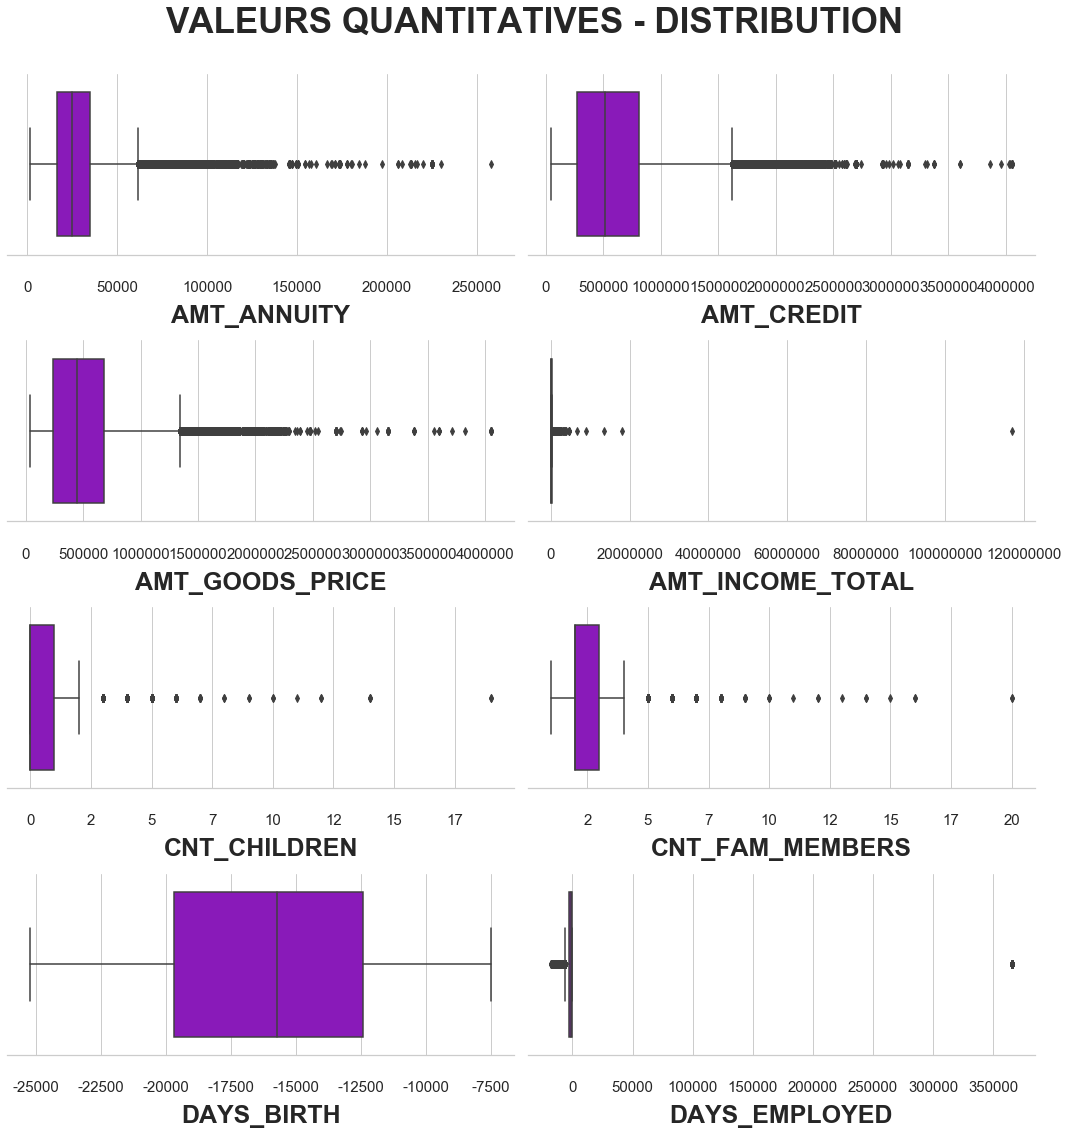

In [11]:
gf.plotBoxPlots(app_train[interesting_cols_quant], 15, 15, 4, 2)

Un outlier ressort clairement du graphe présentant la distribution DAYS_EMPLOYED. 

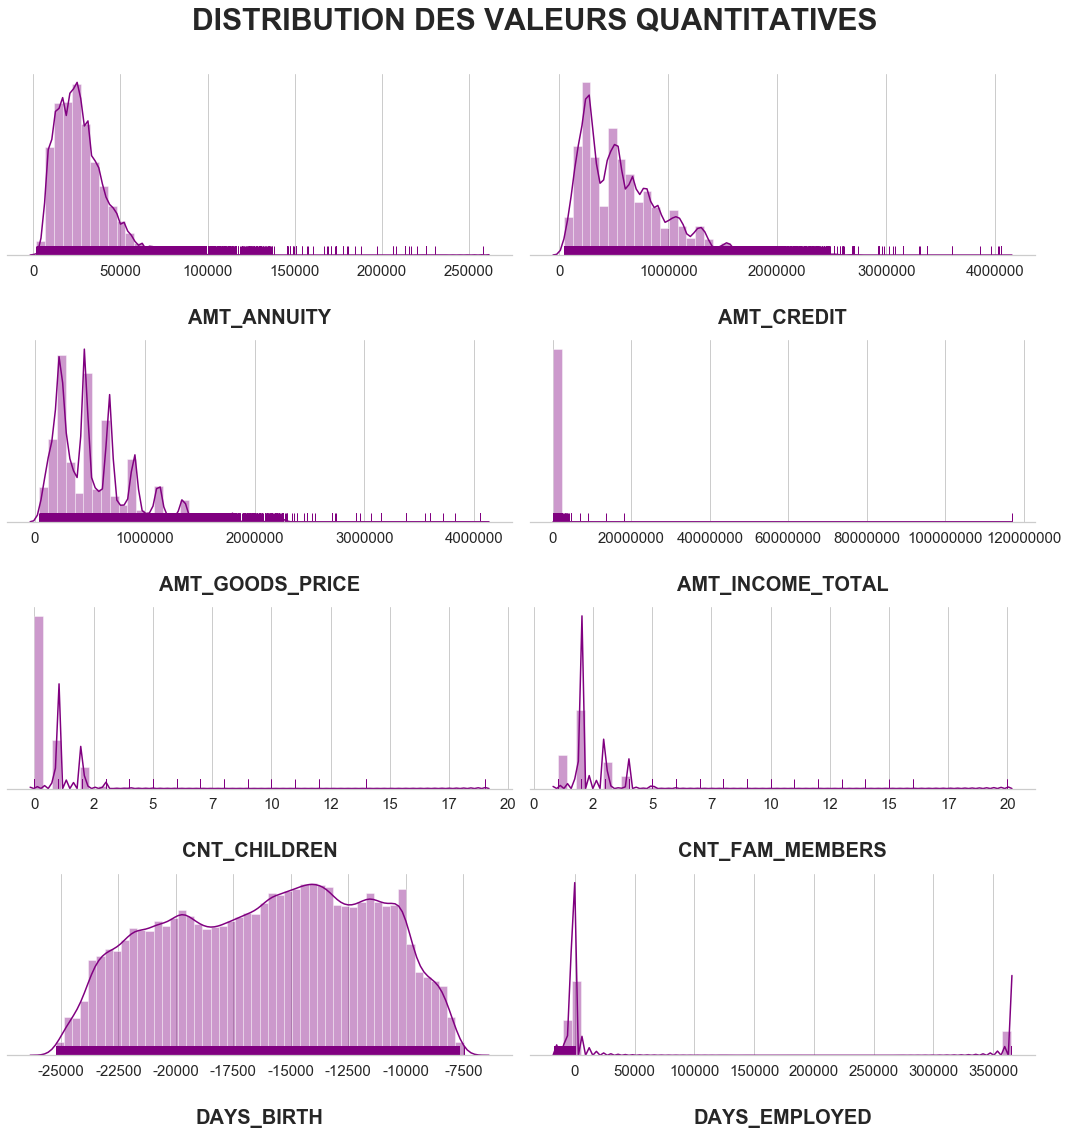

In [12]:
gf.plotDistplotsWithRug(app_train[interesting_cols_quant], 15, 15, 4, 2)

___
##### 1.2.2 _<u>Features qualitatives</u>_

In [14]:
gf.plot_qualitative_dist(app_train[interesting_cols_qual],
                         3, 3, 150, 150, "")

___
##### 1.2.3 _<u>Remboursement des prêts</u>_

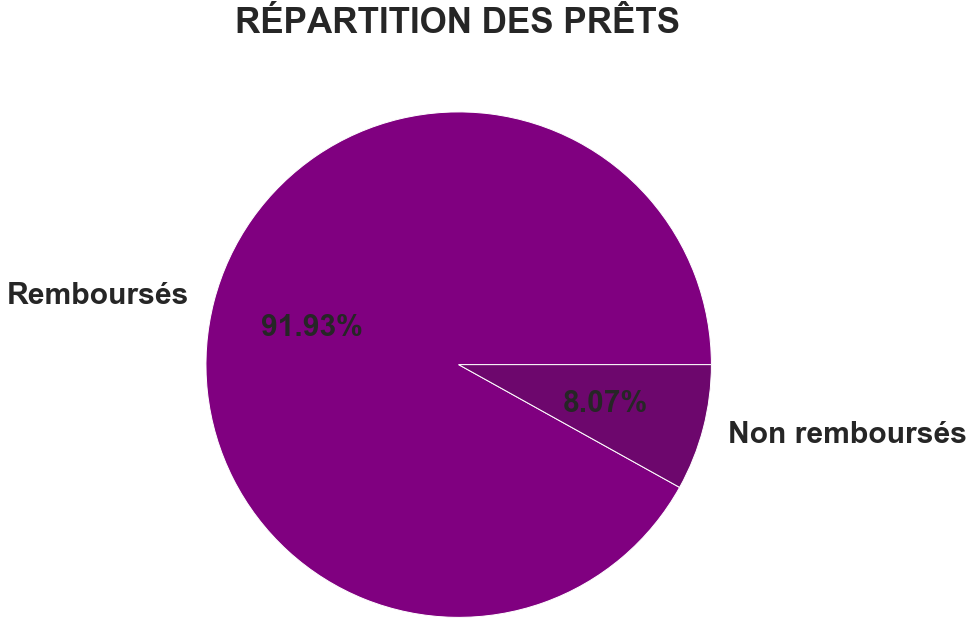

In [14]:
gf.plot_repartition(app_train["TARGET"].map(lambda x: "Remboursés" if x==0 \
                                                     else "Non remboursés"), 
                   "RÉPARTITION DES PRÊTS",
                   10, 10)

Dans notre jeu de données, une large majorité de prêts a été remboursée. 
Il s'agit donc d'un problème avec un déséquilibre de classes. 
Lors de l'étape de modélisation, il faudra donc réfléchir à la méthodologie à employer pour obtenir un modèle performant.

___
#### 1.3 ANOMALIES

Examinons de plus près les outliers repérés dans DAYS_EMPLOYED.

In [15]:
print("L'anomalie concerne {:2.2f}% des données."\
.format(len(app_train[app_train['DAYS_EMPLOYED'] == 365243])/len(app_train)*100))

L'anomalie concerne 18.01% des données.


On a donc ici la même valeur anormale qui concerne près de 20% des clients du jeu de données.

Il est possible que cette valeur ait une signification.

Comparons le taux de défaut des clients concernés par cette anomalie vs celui des autres.

In [18]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Les clients standard ne remboursent pas %0.2f%% des crédits.' % (100 * non_anom['TARGET'].mean()))
print('Les clients concernés par l\'anomalie ne remboursent pas %0.2f%% des crédits.'\
      % (100 * anom['TARGET'].mean()))

Les clients standard ne remboursent pas 8.66% des crédits.
Les clients concernés par l'anomalie ne remboursent pas 5.40% des crédits.


On constate que les clients concernés par cette anomalie ont un taux de défaut plus bas que les autres. 

Lors de l'assemblage des données, nous remplacerons donc cette valeur anormale par NaN, mais garderons une trace de sa présence via une autre colonne.

Pour l'étude des corrélations, nous allons simplement remplacer la valeur anormale par NaN.

In [19]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

___
#### 1.4 CORRÉLATIONS AVEC LE RISQUE DE DÉFAUT TARGET

___
##### 1.4.1 _<u>Corrélations les plus fortes</u>_

In [20]:
correlations = app_train.corr("spearman").drop("TARGET", axis=0)['TARGET'].sort_values(ascending=False)

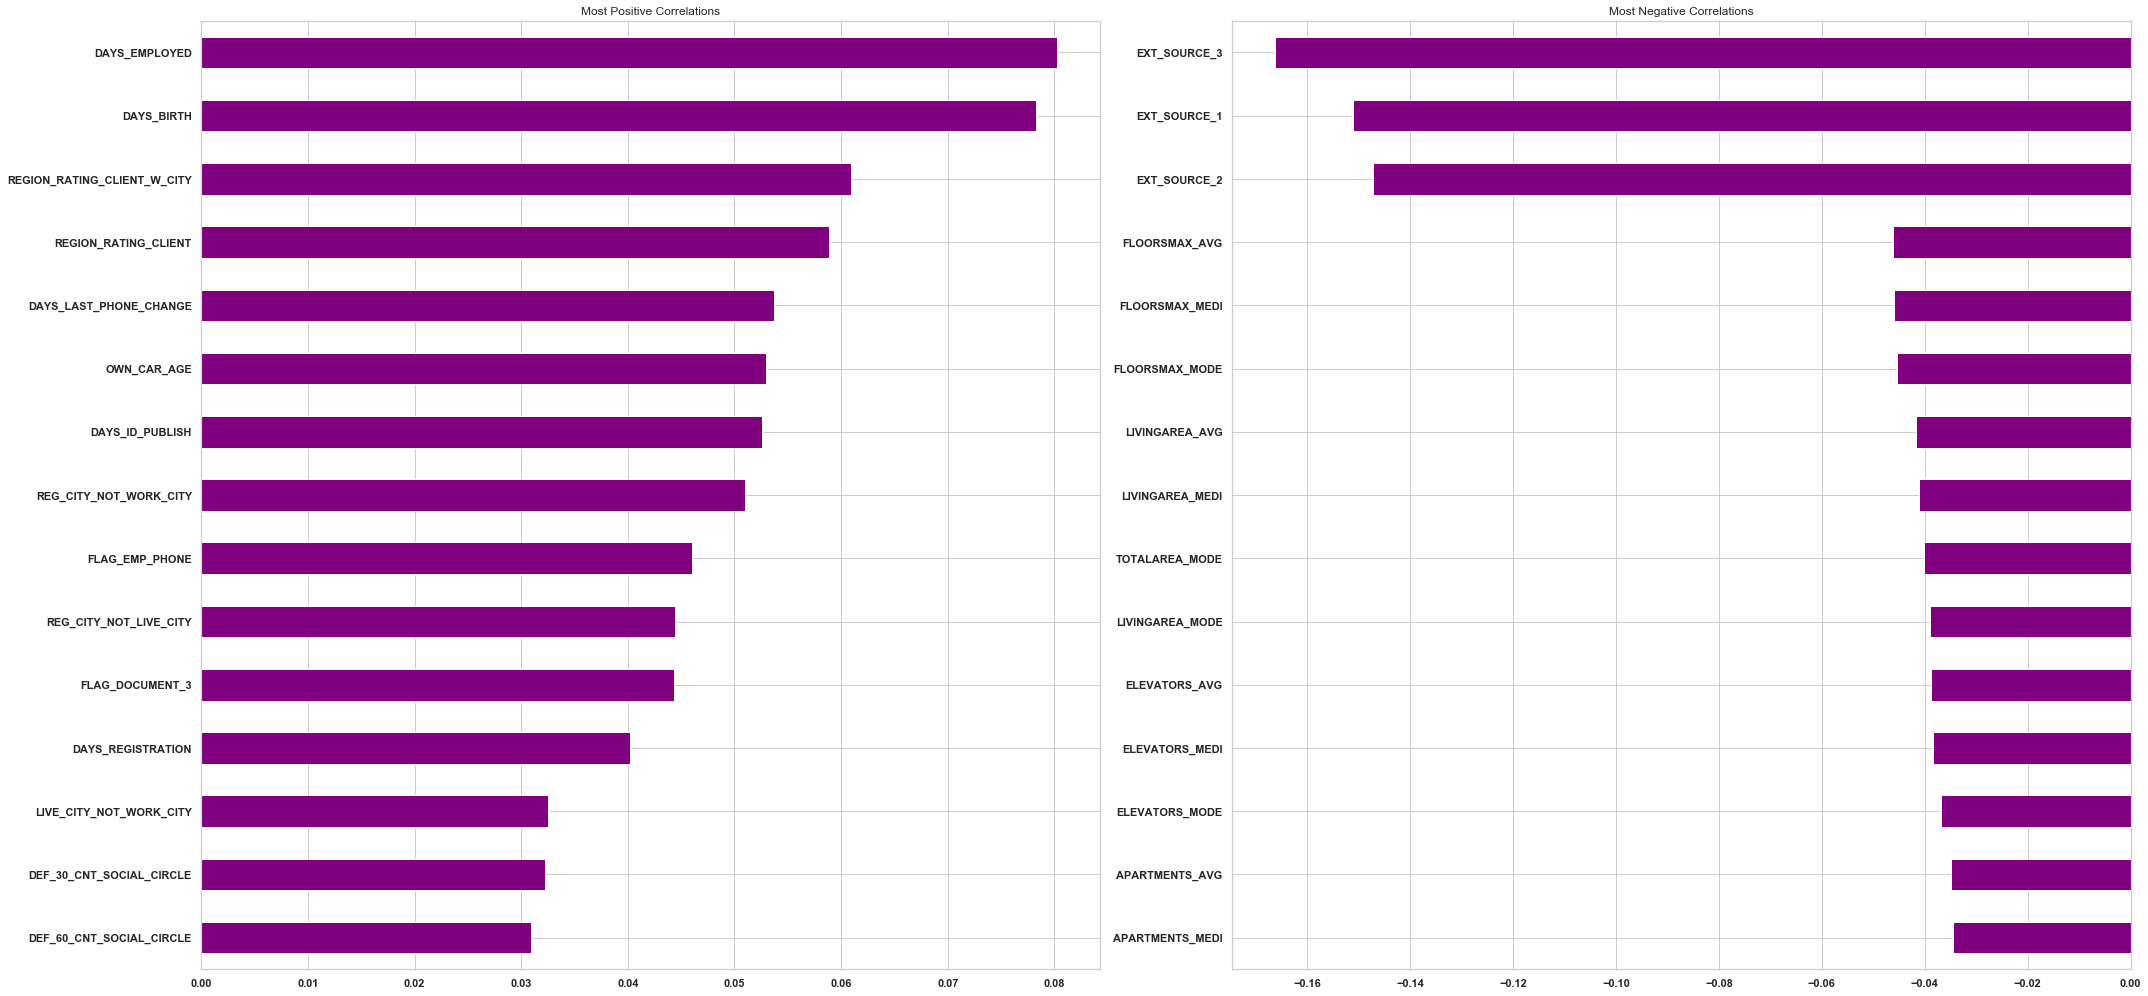

In [26]:
# Display correlations
fig, ax = plt.subplots(1,2, figsize=(30,14))
correlations.head(15).sort_values(ascending=True).plot.barh(ax = ax[0], 
                                                            title='Most Positive Correlations')
correlations.tail(15).plot.barh(ax = ax[1], 
                                title='Most Negative Correlations')
plt.tight_layout(h_pad = 2.5)

- Le nombre de jours d'ancienneté et l'âge ont les corrélations positives les plus fortes avec TARGET.
- Les indicateurs synthétiques ont les corrélations négatives les plus fortes avec TARGET.

___
##### 1.4.2 _<u>Focus : corrélation avec l'ancienneté au poste actuel DAYS_EMPLOYED</u>_

In [31]:
app_train["YEARS_EMPLOYED"] = app_train["DAYS_EMPLOYED"]/(-365)

In [32]:
# Age information into a separate dataframe
emploi_data = app_train[['TARGET', 'YEARS_EMPLOYED']].copy()

# Bin the age data
emploi_data['YEARS_EMPLOYED_BINNED'] = pd.cut(emploi_data['YEARS_EMPLOYED'], 
                                              bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
emploi_groups  = emploi_data.groupby('YEARS_EMPLOYED_BINNED').mean()

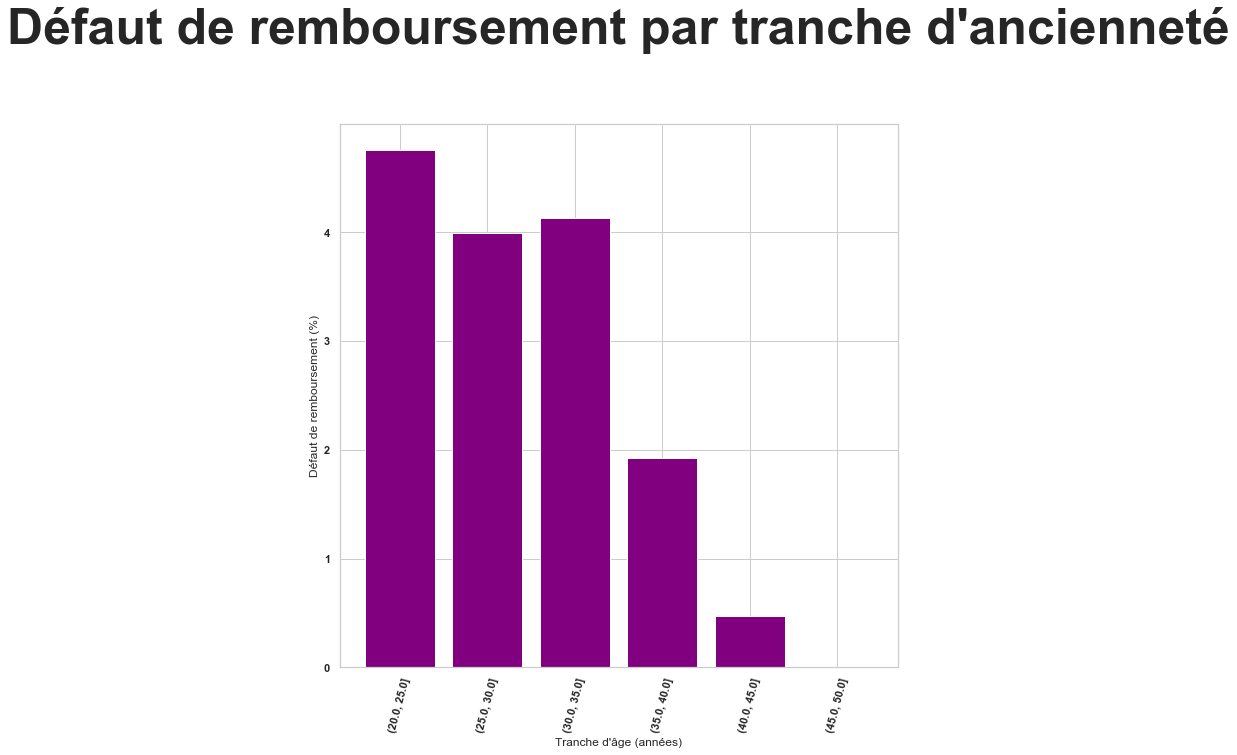

In [33]:
gf.plot_barplot(emploi_groups, 
                "TARGET", 
                "Défaut de remboursement par tranche d'ancienneté", 
                10, 10)

On observe qu'à partir de 35 ans d'ancienneté, le risque de défaut de paiement est divisé par plus de 2 par rapport aux autres employés ayant moins d'ancienneté.

___
##### 1.4.3 _<u>Focus : corrélation avec l'âge (DAYS_BIRTH)</u>_

In [27]:
app_train["AGE"] = app_train["DAYS_BIRTH"]/(-365)

<Figure size 432x288 with 0 Axes>

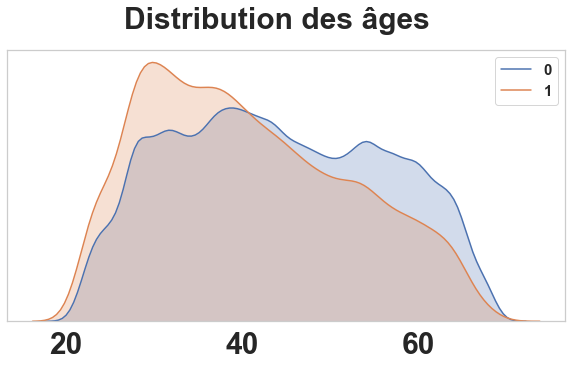

In [28]:
gf.plotKDE(app_train[["AGE", "TARGET"]], "AGE", "TARGET", 10, 5, "Distribution des âges")

On observe que le nombre de défauts de paiement semble décroître avec l'âge.

Explorons le nombre de défauts de paiement par tranche d'âge.

In [29]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'AGE']].copy()

# Bin the age data
age_data['AGE_BINNED'] = pd.cut(age_data['AGE'], bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
age_groups  = age_data.groupby('AGE_BINNED').mean()

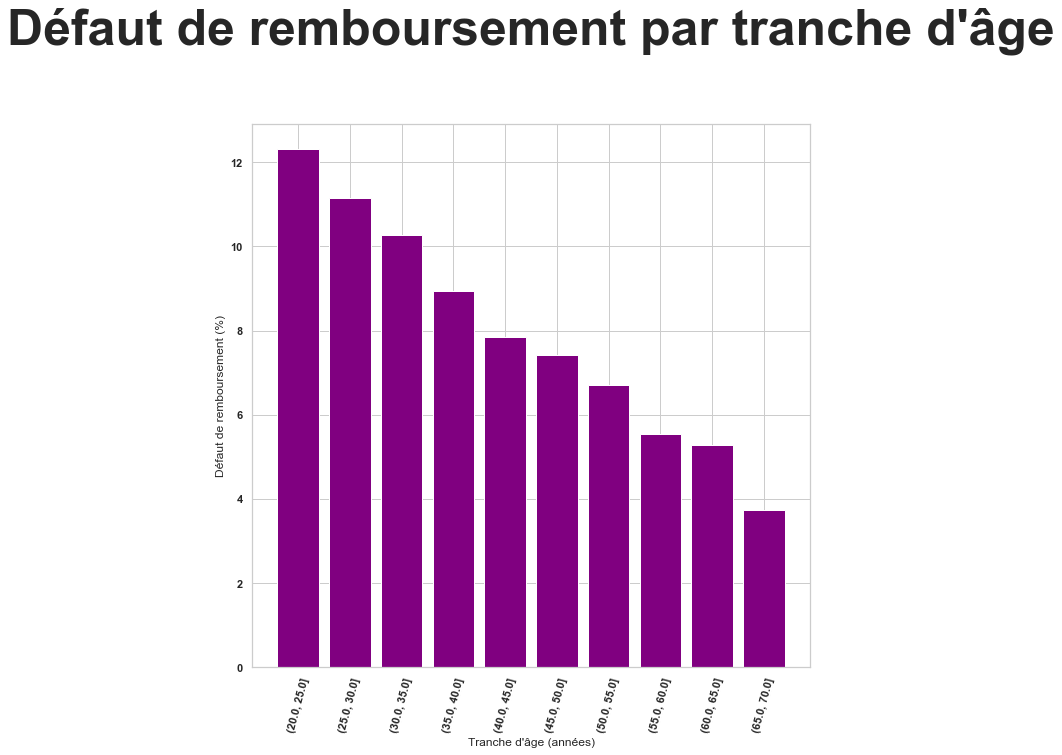

In [30]:
gf.plot_barplot(age_groups, 
                "TARGET", 
                "Défaut de remboursement par tranche d'âge", 
                10, 10)

L'histogramme par tranche d'âge confirme nos premières observations : 
Le taux de défaut de remboursement est supérieur à 10% pour les tranches d'âges les plus basses, et inférieur à 5% pour les trois tranches d'âge les plus élevées.

___
##### 1.4.4 _<u>Focus : corrélation avec les indicateurs synthétiques EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3</u>_

In [34]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 
                      'EXT_SOURCE_1', 
                      'EXT_SOURCE_2', 
                      'EXT_SOURCE_3', 
                      'DAYS_BIRTH']]

ext_data_corrs = ext_data.corr("spearman")

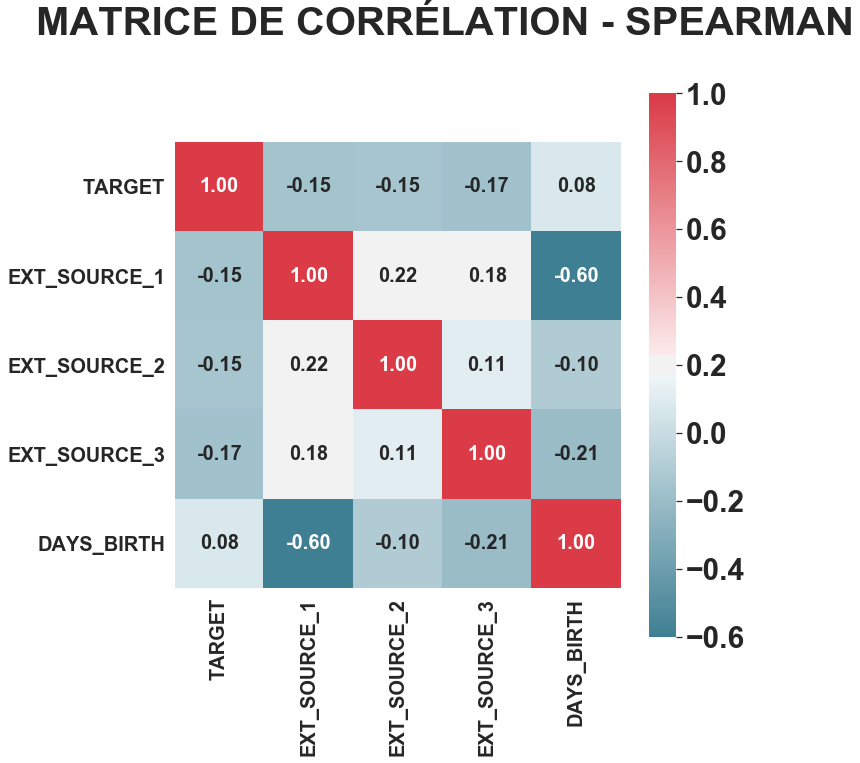

In [41]:
gf.plot_correlation_heatmap(ext_data_corrs, 10, 10)

On remarque une forte corrélation négative entre l'âge et EXT_SOURCE_1.

**EXT_SOURCE_1**

<Figure size 432x288 with 0 Axes>

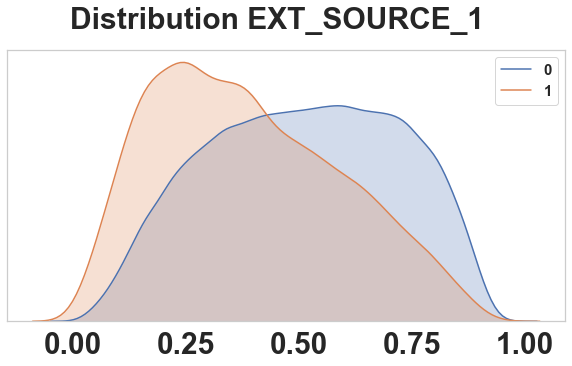

In [36]:
gf.plotKDE(app_train[["EXT_SOURCE_1", "TARGET"]], 
           "EXT_SOURCE_1", 
           "TARGET", 10, 5, 
           "Distribution EXT_SOURCE_1")

**EXT_SOURCE_2**

<Figure size 432x288 with 0 Axes>

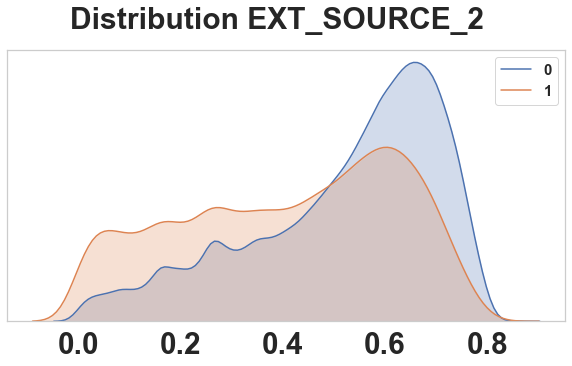

In [37]:
gf.plotKDE(app_train[["EXT_SOURCE_2", "TARGET"]], 
           "EXT_SOURCE_2", 
           "TARGET", 10, 5, 
           "Distribution EXT_SOURCE_2")

**EXT_SOURCE_3**

<Figure size 432x288 with 0 Axes>

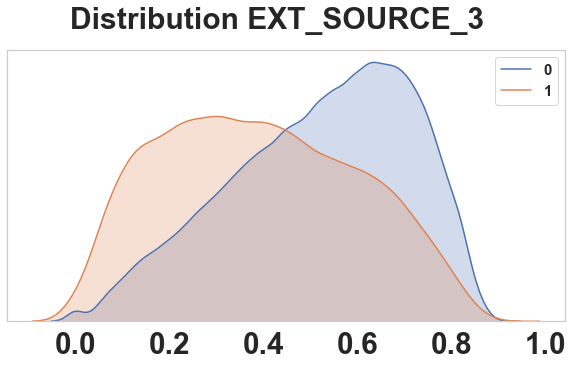

In [38]:
gf.plotKDE(app_train[["EXT_SOURCE_3", "TARGET"]], 
           "EXT_SOURCE_3", 
           "TARGET", 10, 5, 
           "Distribution EXT_SOURCE_3")

La variable EXT_SOURCE_3 présente les variations les plus importantes dans sa distribution entre prêts remboursés / non-remboursés.

___
### 2. Conclusion
___

L'analyse a pu mettre en lumière plusieurs informations importantes pour la modélisation à venir :
- Un tiers des features du jeu de données ont 50% de valeurs manquantes.
- Le nombre de jours d'emploi de certains clients présente la même valeur anormale
- des corrélations existent - bien que toutes globalement faibles - entre le taux de remboursement des crédits et certaines features du jeu de données, en particulier l'âge, le nombre de jours employé·e et les 3 indicateurs synthétiques.